In [157]:
import os
import tensorflow as tf
import tensorflow_probability as tfp
tfpl = tfp.layers
tf1 = tf.compat.v1
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [158]:
from tensorflow_probability.python.distributions import kl_divergence

In [159]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

In [160]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [161]:
hf = h5py.File('/mnt/data/HSC/HSC_v6/extra_files/five_band_image127x127_full.hdf5', 'r')

In [162]:
n = 5000

In [163]:
x = np.asarray(hf["image"][0:n]).astype('float32')
y = np.asarray(hf["specz"][0:n]).astype('float32')

In [164]:
y = y[:,0]

In [165]:
x.shape

(5000, 5, 127, 127)

In [166]:
x = np.transpose(x,(0,2,3,1))
max_value = np.max(x)
min_value = np.min(x)
x_new = np.true_divide(np.subtract(x,min_value),max_value - min_value)

In [167]:
hf.close()

In [168]:
x_train, x_test, y_train, y_test = train_test_split(x_new,y,test_size=0.2)

In [169]:
kl_divergence_function = lambda q, p, _: kl_divergence(q, p) / n

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='tanh',input_shape=(120,120,5)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size=(2,2),activation='tanh'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size=(3,3),activation='relu'))
model.add(Conv2D(32, kernel_size=(2,2),activation='relu'))
model.add(Flatten())
model.add(Dense(500, activation="tanh"))
model.add(Dense(100, activation="tanh"))
model.add(Dense(1))

In [170]:
def posterior_mean_field(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype, initializer=lambda shape, dtype: random_gaussian_initializer(shape, dtype), trainable=True),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale= + 10e-4*tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])

def prior_trainable(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),  # Returns a trainable variable of shape n, regardless of input
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])

def random_gaussian_initializer(shape, dtype):
    n = int(shape / 2)
    loc_norm = tf.random_normal_initializer(mean=0., stddev=0.1)
    loc = tf.Variable(
        initial_value=loc_norm(shape=(n,), dtype=dtype)
    )
    scale_norm = tf.random_normal_initializer(mean=-3., stddev=0.1)
    scale = tf.Variable(
        initial_value=scale_norm(shape=(n,), dtype=dtype)
    )
    return tf.concat([loc, scale], 0)

def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

In [176]:
model_variational = Sequential([
    tf.keras.Input(shape=(127,127,5),name="basket"),
    
    tfp.layers.Convolution2DFlipout(32, kernel_size=(2,2), activation='tanh', 
                                    kernel_divergence_fn=kl_divergence_function),
    MaxPooling2D(2,2),
    
    tfp.layers.Convolution2DFlipout(32, kernel_size=(2,2), activation='tanh', 
                                    kernel_divergence_fn=kl_divergence_function),
    MaxPooling2D(2,2),
    
    tfp.layers.Convolution2DFlipout(32, kernel_size=(2,2), activation='relu', 
                                    kernel_divergence_fn=kl_divergence_function),
    
    tfp.layers.Convolution2DFlipout(32, kernel_size=(2,2), activation='relu', 
                                    kernel_divergence_fn=kl_divergence_function),
    tf.keras.layers.Flatten(),
    # tfp.layers.DenseVariational(512, activation='tanh', make_posterior_fn=posterior_mean_field, make_prior_fn=prior_trainable, kl_weight=1/n),
    Dense(512, activation='tanh'),
    # tfp.layers.DenseVariational(128, activation='tanh', make_posterior_fn=posterior_mean_field, make_prior_fn=prior_trainable, kl_weight=1/n),
    Dense(128, activation='tanh'),
    tfp.layers.IndependentNormal(1)
])

model_variational.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout_52 (Conv2DFli (None, 126, 126, 32)      1312      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_flipout_53 (Conv2DFli (None, 62, 62, 32)        8224      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_flipout_54 (Conv2DFli (None, 30, 30, 32)        8224      
_________________________________________________________________
conv2d_flipout_55 (Conv2DFli (None, 29, 29, 32)        8224      
_________________________________________________________________
flatten_12 (Flatten)         (None, 26912)            

divergence_fn = lambda q,p,_:kl_divergence(q,p)/(n)

model_variational = Sequential([
    
    tfpl.Convolution2DReparameterization(input_shape = (120,120,5), filters = 32, kernel_size = (2,2), activation='tanh',
                                           kernel_prior_fn = tfpl.default_mean_field_normal_fn(is_singular=False,loc_initializer=tf1.initializers.random_normal(stddev=1e-4)),
                                           kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False,loc_initializer=tf1.initializers.random_normal(stddev=1e-4)),
                                           kernel_divergence_fn = divergence_fn,
                                           bias_prior_fn = tfpl.default_mean_field_normal_fn(is_singular=False,loc_initializer=tf1.initializers.random_normal(stddev=1e-4)),
                                           bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False,loc_initializer=tf1.initializers.random_normal(stddev=1e-4)),
                                           bias_divergence_fn = divergence_fn),
    MaxPooling2D(2,2),
    Conv2D(32, (2,2), activation='tanh'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    Conv2D(32, (2,2), activation='relu'),
    Flatten(),
    Dense(512, activation='tanh'),
    Dense(128, activation='tanh'),
    tfpl.DenseReparameterization(2, activation=None, kernel_prior_fn = tfpl.default_mean_field_normal_fn(is_singular=False,loc_initializer=tf1.initializers.random_normal(stddev=1e-4)), kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False,loc_initializer=tf1.initializers.random_normal(stddev=1e-4)), kernel_divergence_fn = divergence_fn, bias_prior_fn = tfpl.default_mean_field_normal_fn(is_singular=False,loc_initializer=tf1.initializers.random_normal(stddev=1e-4)), bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False,loc_initializer=tf1.initializers.random_normal(stddev=1e-4)), bias_divergence_fn = divergence_fn),
    tfp.layers.IndependentNormal(1)
    
])
model_variational.summary()

In [154]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

model_variational.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss = negative_loglikelihood, metrics=[keras.metrics.RootMeanSquaredError()])

In [155]:
model_variational.fit(x = x_train, y = y_train, epochs = 300, shuffle = True, verbose=1)

Epoch 1/300


AttributeError: in user code:

    /opt/anaconda3/envs/jupyterhub/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    <ipython-input-34-f43e6cae44e3>:2 negative_loglikelihood  *
        return -estimated_distribution.log_prob(targets)
    /opt/anaconda3/envs/jupyterhub/lib/python3.8/site-packages/tensorflow/python/framework/ops.py:401 __getattr__
        self.__getattribute__(name)

    AttributeError: 'Tensor' object has no attribute 'log_prob'


In [146]:
model_variational.predict(np.array([x_train[0],x_train[1]]))

array([[0.12483683],
       [0.13288093]], dtype=float32)

In [147]:
model_variational(np.array([x_train[0]])).mean()[0][0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.41648513>

In [148]:
y_train[0]

0.8492

In [149]:
y_test_prediction = []

for i in range(len(y_test)):
    y_test_prediction.append(model_variational(np.array([x_test[i]])).mean()[0][0])

y_test_prediction = np.asarray(y_test_prediction).astype('float32')

y_test_spectro = np.asarray(y_test)

In [150]:
from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([y_test_spectro,y_test_prediction])).astype('float32')
z = gaussian_kde(xy)(xy)

(0.0, 2.0)

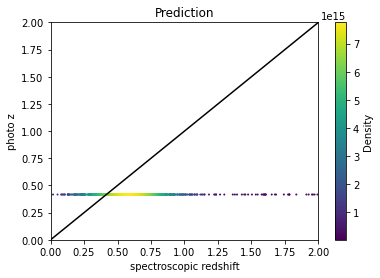

In [151]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_test_spectro, y_test_prediction, c = z, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
plt.title('Prediction')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, 2], [0, 2],color = 'black')
plt.xlim([0, 2])
plt.ylim([0, 2])

In [152]:
# END